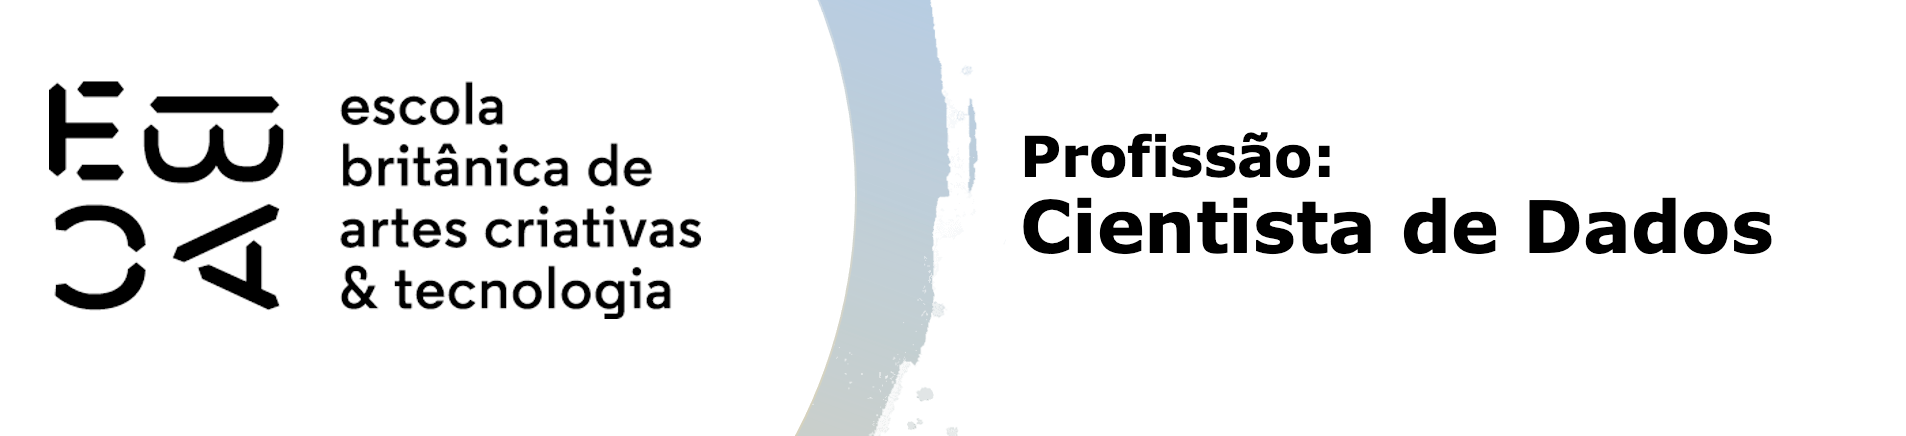

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [112]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [152]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [156]:
df['data_ref'] = pd.to_datetime(df['data_ref'])

data_corte = df['data_ref'].max() - pd.DateOffset(months=3)
validacao_oot = df[df['data_ref'] > data_corte]

treinamento = df[df['data_ref'] <= data_corte]

In [130]:
treinamento.shape, validacao_oot.shape

((600000, 15), (150000, 15))

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [21]:

num_linhas = df.shape[0]
print(f"Número total de linhas: {num_linhas}")


df['data_ref'] = pd.to_datetime(df['data_ref'])  
df['mes'] = df['data_ref'].dt.to_period('M')  
contagem_mensal = df['mes'].value_counts().sort_index()
print("\nNúmero de linhas para cada mês:")
print(contagem_mensal)

variaveis_quantitativas = df.select_dtypes(include=['float64', 'int64'])
descritiva_quantitativa = variaveis_quantitativas.describe()
print("\nDescritiva básica univariada (variáveis quantitativas):")
print(descritiva_quantitativa)


variaveis_qualitativas = df.select_dtypes(include=['object'])
descritiva_qualitativa = {col: df[col].value_counts() for col in variaveis_qualitativas.columns}
print("\nDescritiva básica univariada (variáveis qualitativas):")
for col, counts in descritiva_qualitativa.items():
    print(f"\n{col}:")
    print(counts)

Número total de linhas: 750000

Número de linhas para cada mês:
mes
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: count, dtype: int64

Descritiva básica univariada (variáveis quantitativas):
               index     qtd_filhos          idade  tempo_emprego  \
count  750000.000000  750000.000000  750000.000000  624043.000000   
mean     8319.272793       0.433251      43.804733       7.748574   
std      4809.281774       0.739379      11.229868       6.687455   
min         0.000000       0.000000      22.000000       0.117808   
25%      4147.000000       0.000000      34.000000       3.049315   
50%      8324.000000       0.000000      43.000000       6.046575   
75%     12487.000000       1.000000      53.000000      10.183562   
max     16649.000000      14.0000

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Matriz de Correlação:
                          index  qtd_filhos     idade  tempo_emprego  \
index                  1.000000    0.030967 -0.047098      -0.034562   
qtd_filhos             0.030967    1.000000 -0.370234      -0.075299   
idade                 -0.047098   -0.370234  1.000000       0.330063   
tempo_emprego         -0.034562   -0.075299  0.330063       1.000000   
qt_pessoas_residencia  0.032696    0.890352 -0.341151      -0.066361   
renda                 -0.011548   -0.041886  0.101772       0.496360   

                       qt_pessoas_residencia     renda  
index                               0.032696 -0.011548  
qtd_filhos                          0.890352 -0.041886  
idade                              -0.341151  0.101772  
tempo_emprego                      -0.066361  0.496360  
qt_pessoas_residencia               1.000000 -0.047790  
renda                              -0.047790  1.000000  


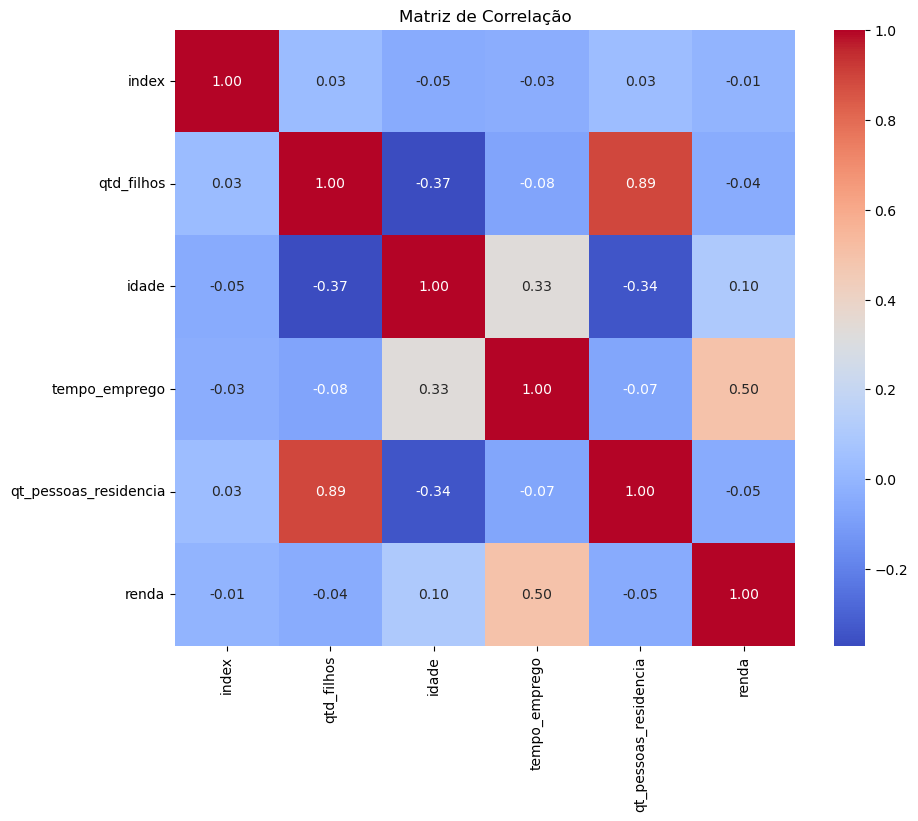


Tabela de Contingência entre sexo e posse_de_veiculo:
posse_de_veiculo       N       S
sexo                            
F                 371028  133552
M                  86926  158494

Tabela de Contingência entre sexo e posse_de_imovel:
posse_de_imovel       N       S
sexo                           
F                156662  347918
M                 89646  155774

Tabela de Contingência entre sexo e tipo_renda:
tipo_renda  Assalariado  Bolsista  Empresário  Pensionista  Servidor público
sexo                                                                        
F                235395       361      113774       108016             47034
M                150345         0       58938        18249             17888

Tabela de Contingência entre sexo e educacao:
educacao  Fundamental   Médio  Pós graduação  Superior completo  \
sexo                                                              
F                5403  342166            591             137952   
M                3172  164

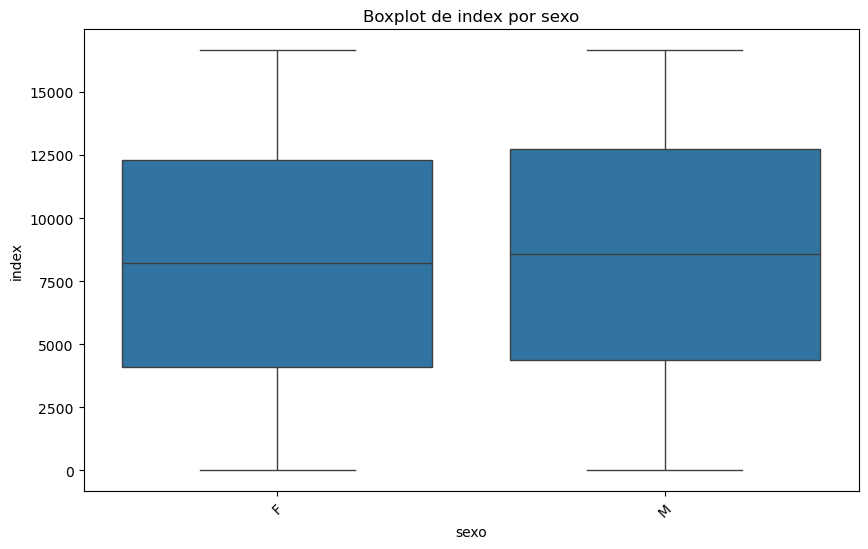

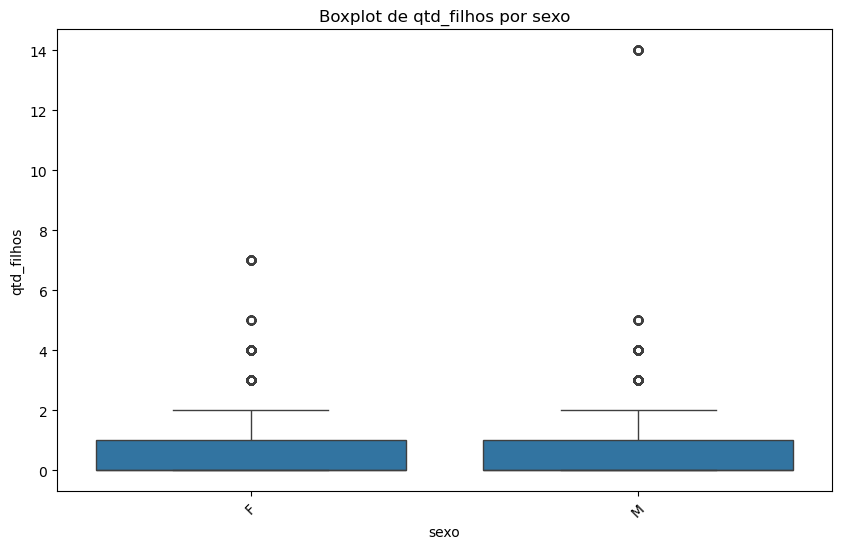

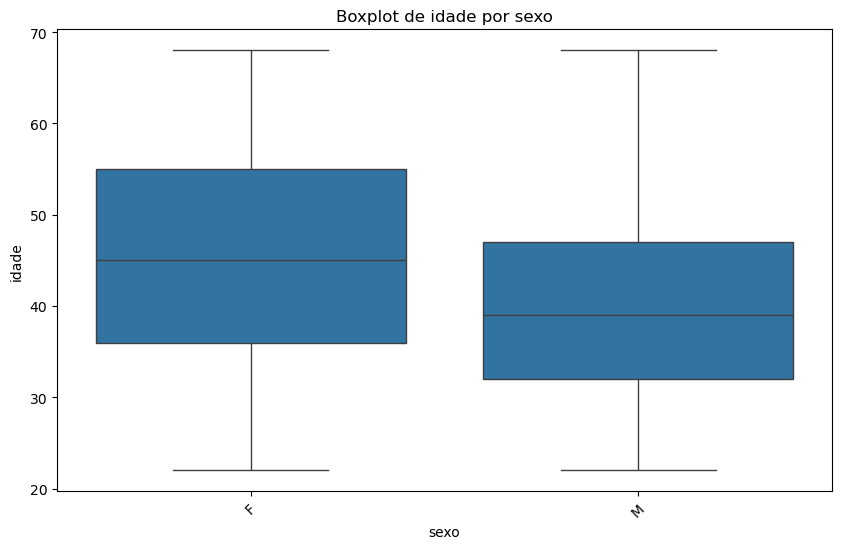

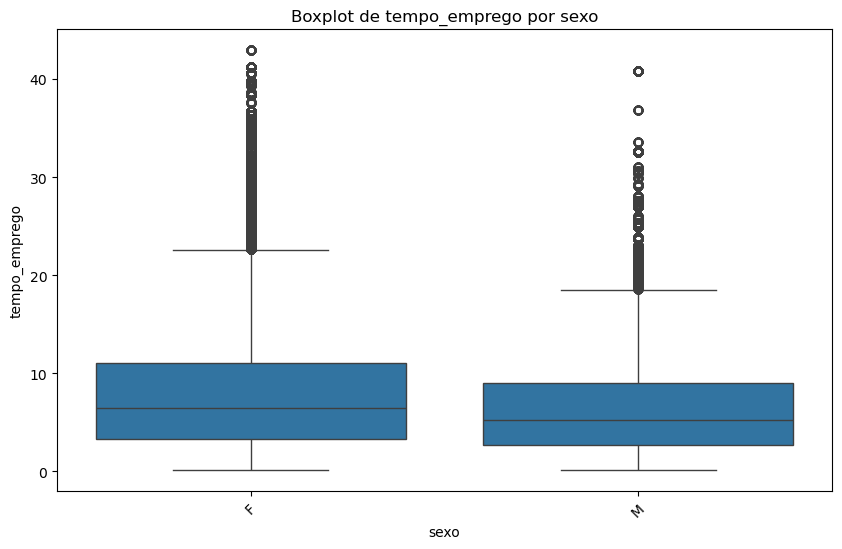

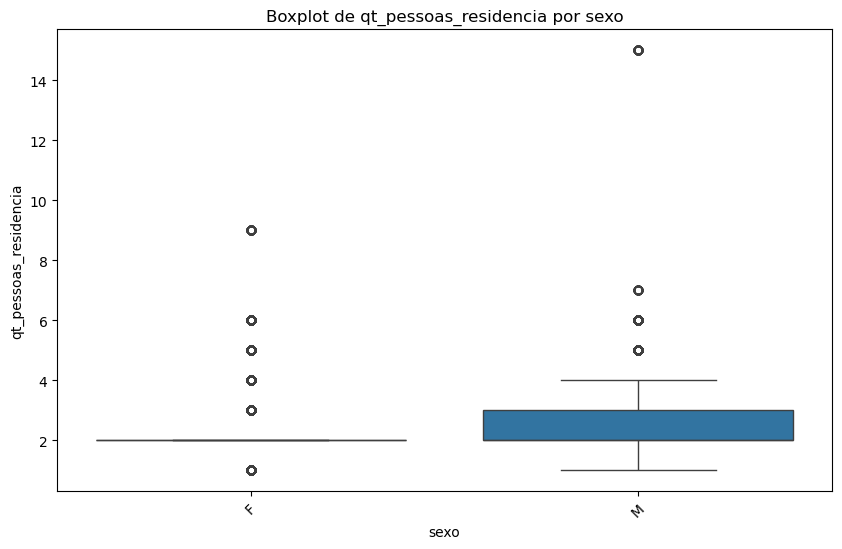

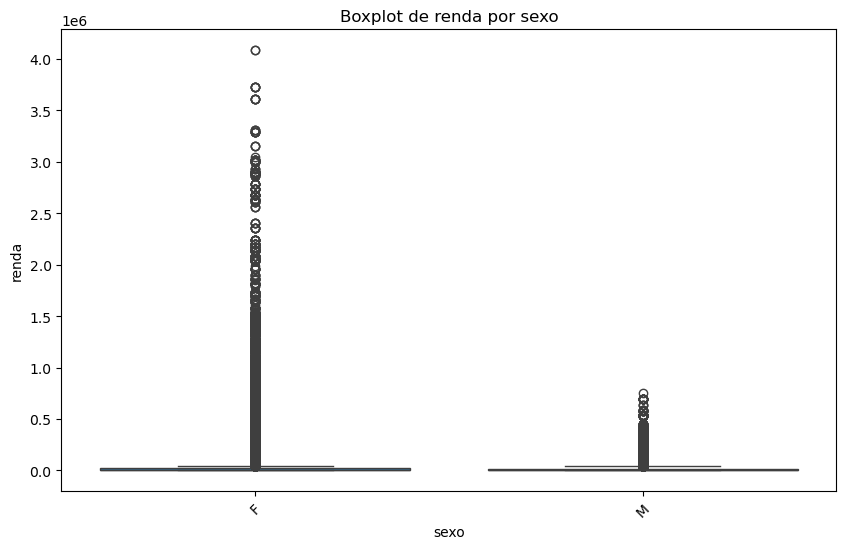

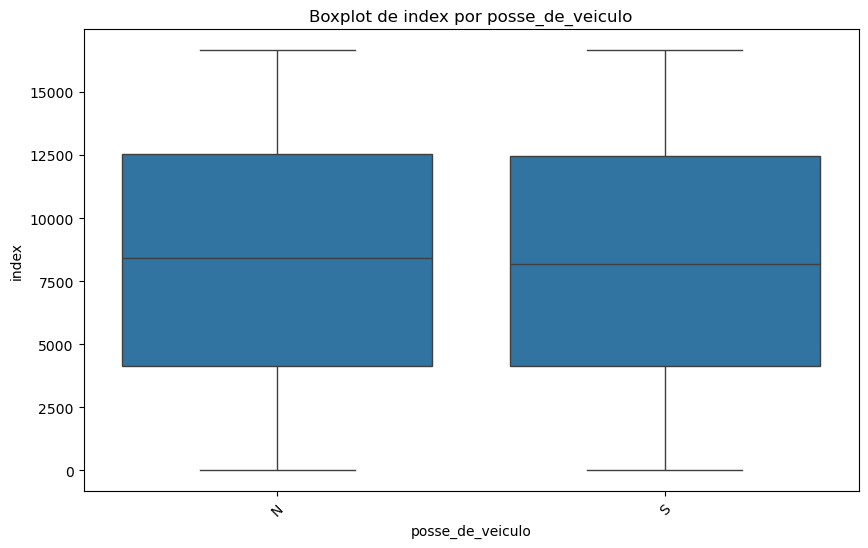

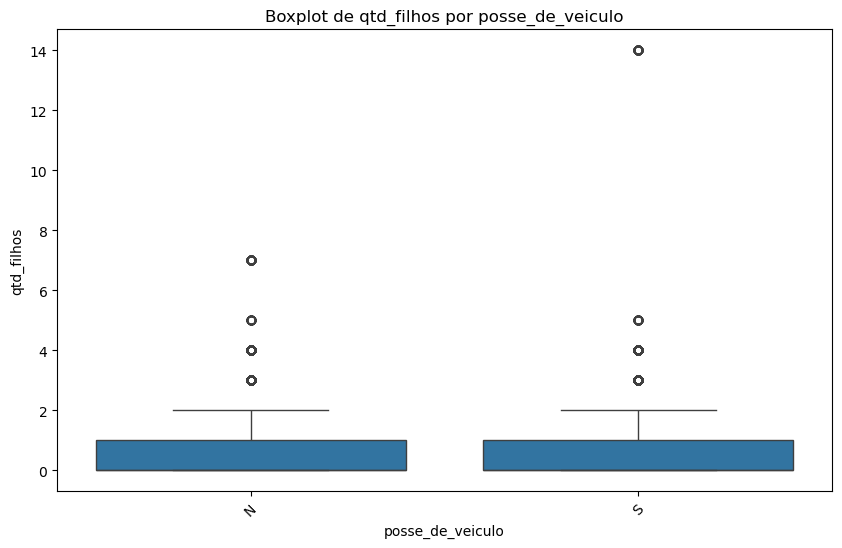

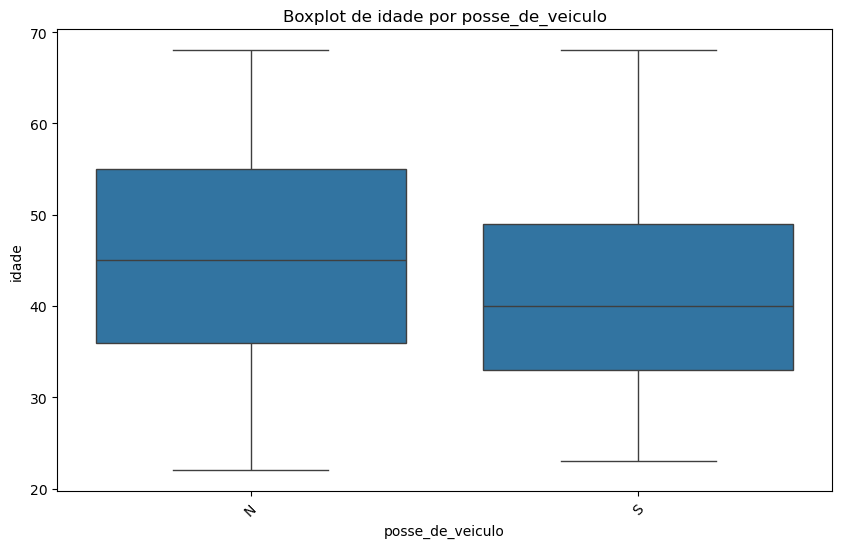

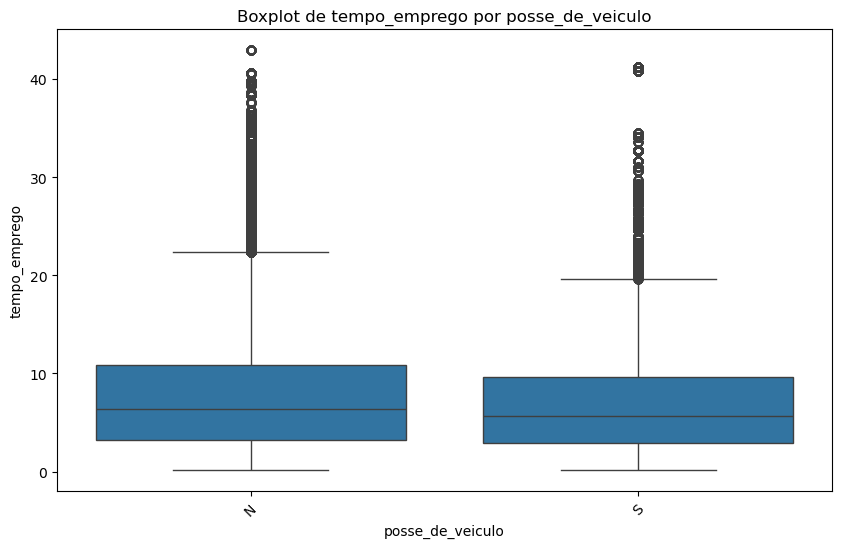

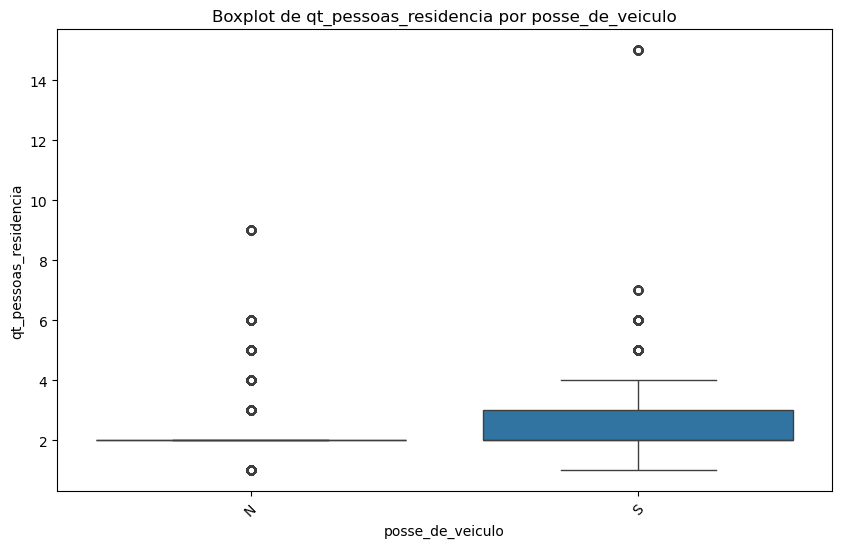

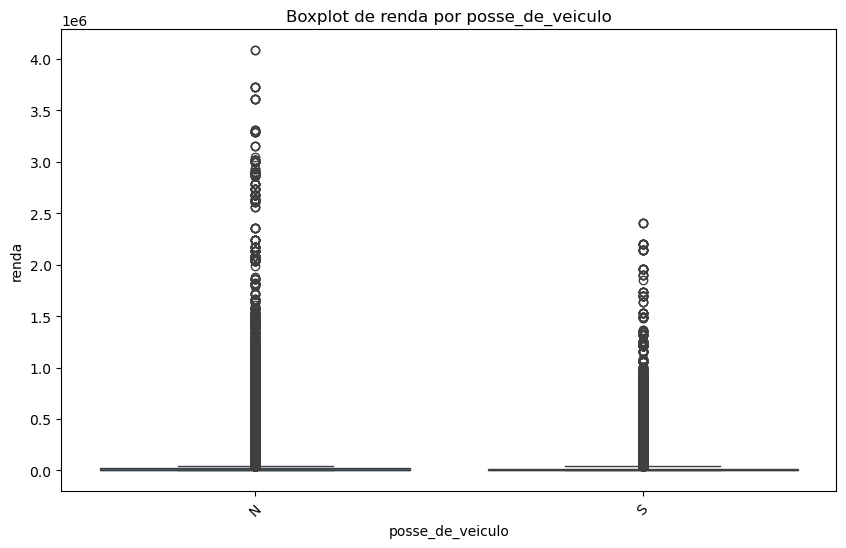

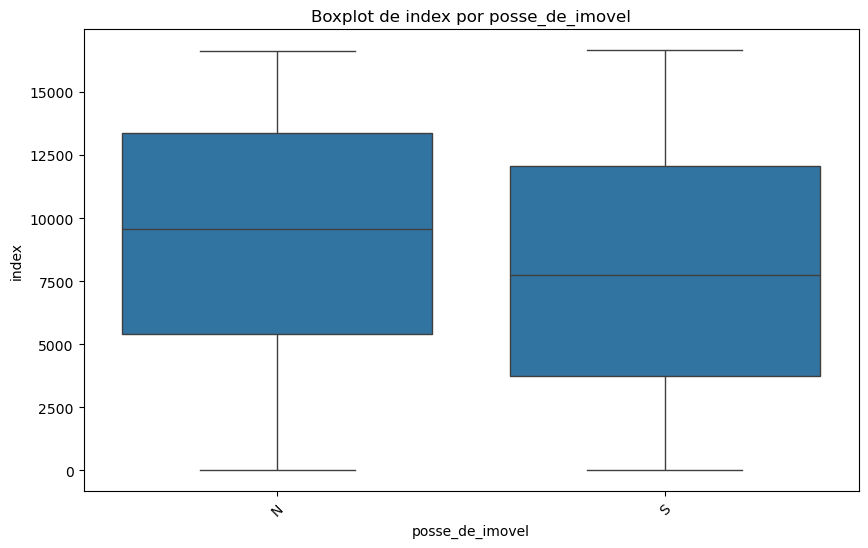

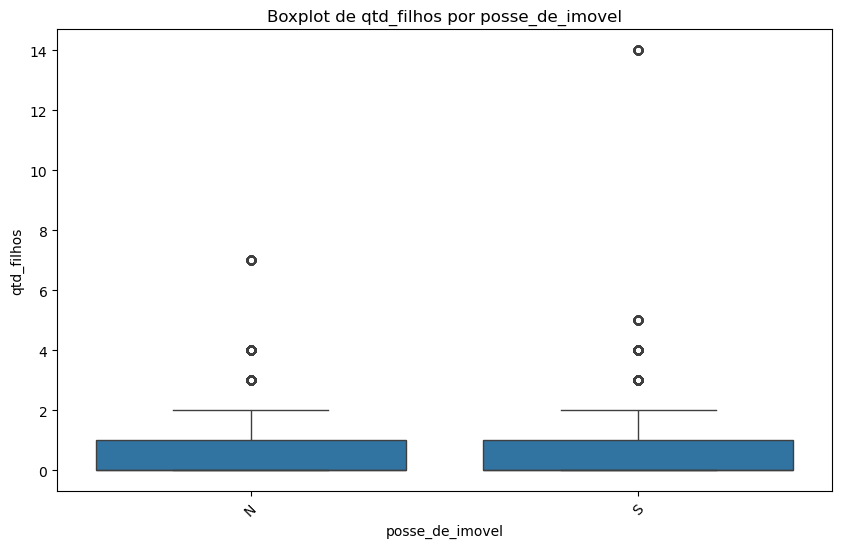

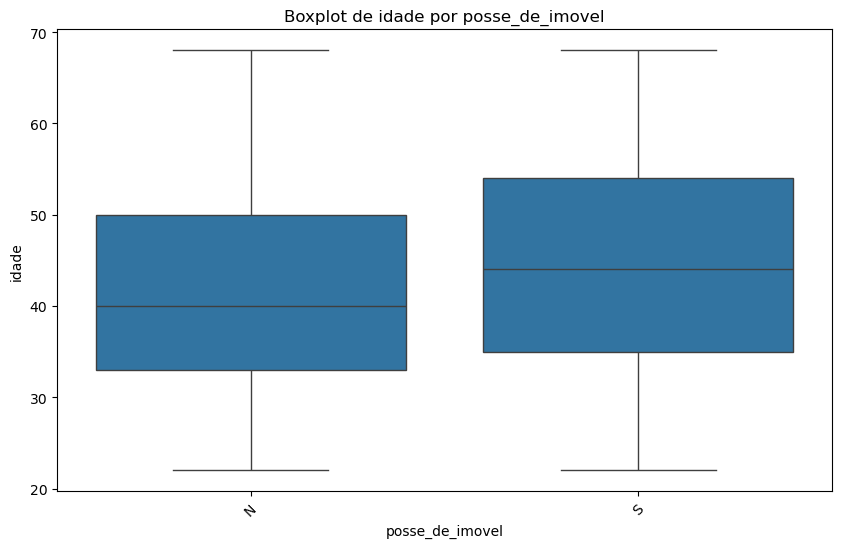

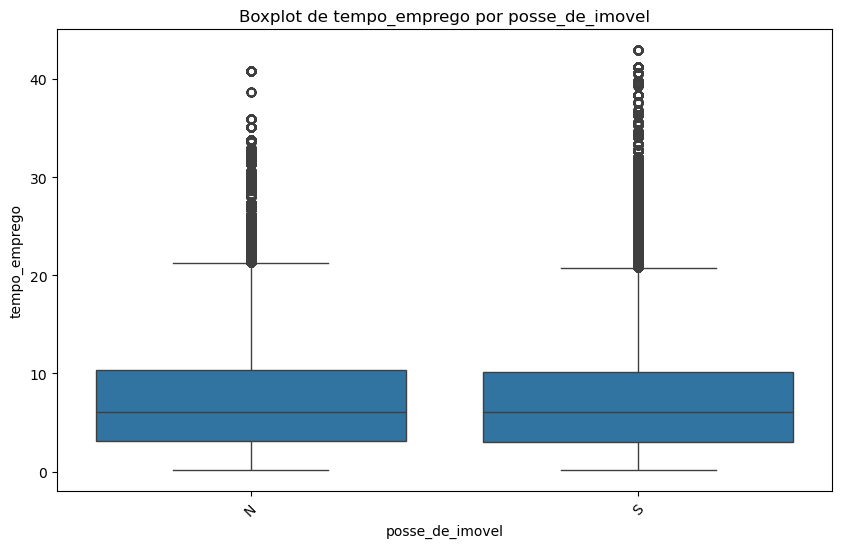

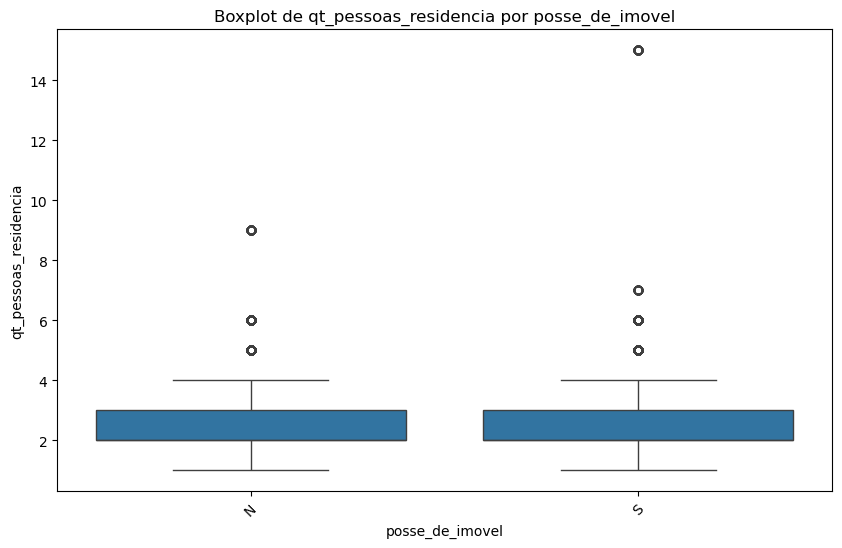

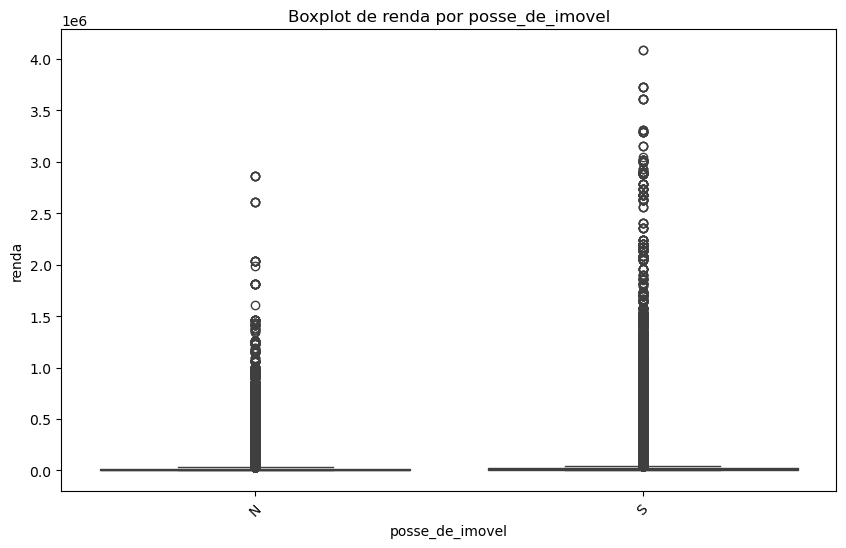

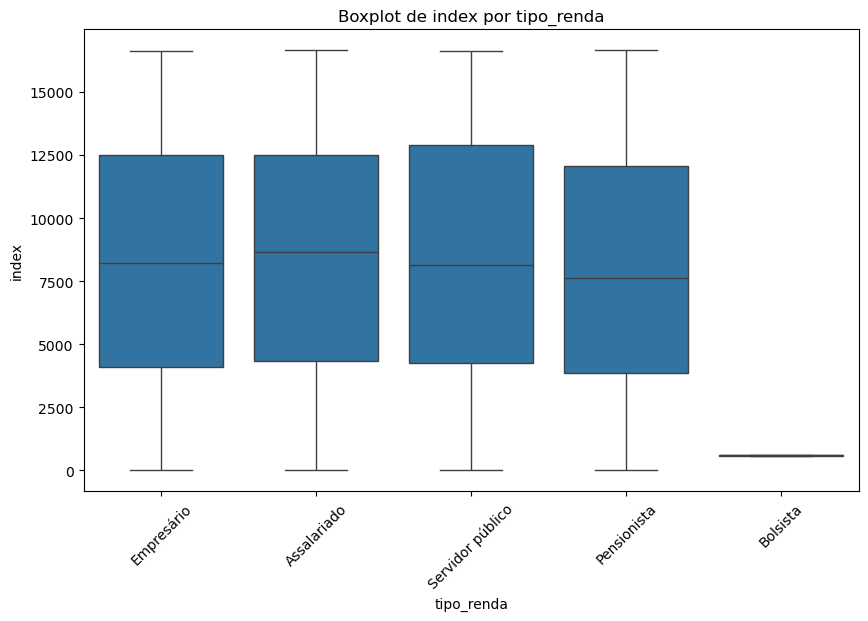

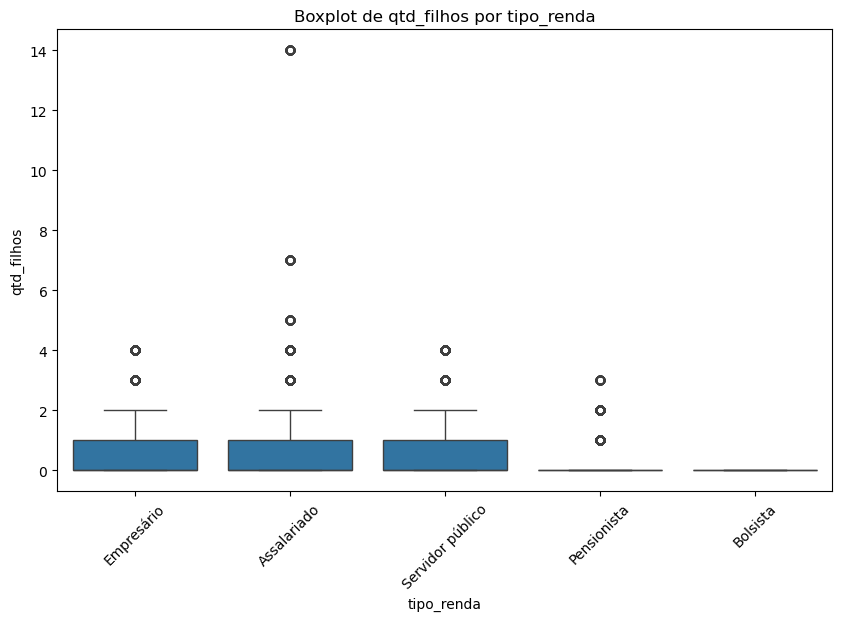

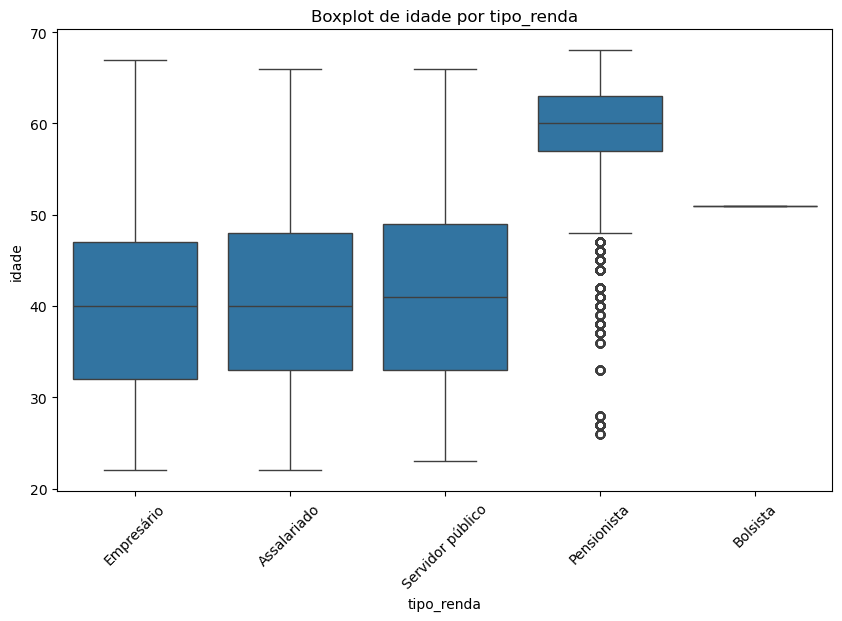

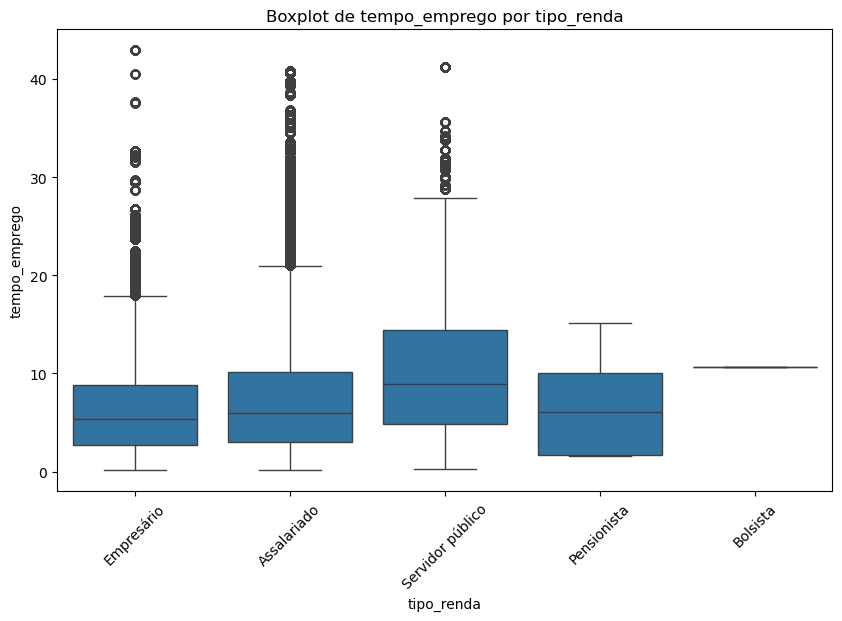

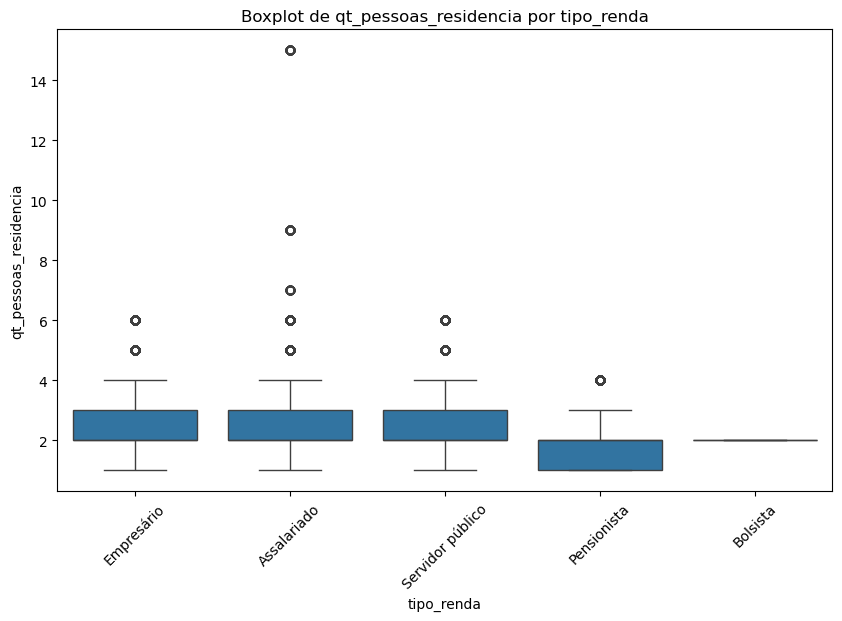

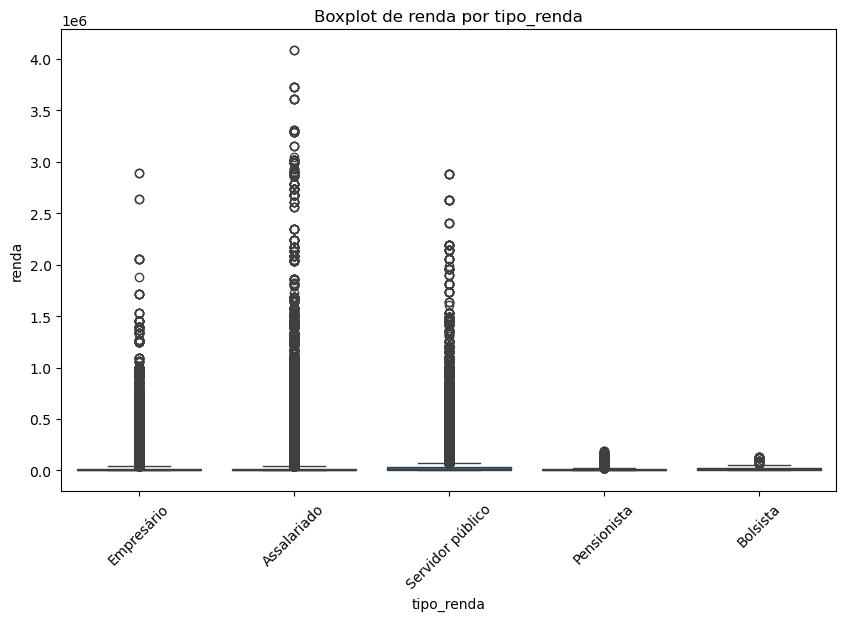

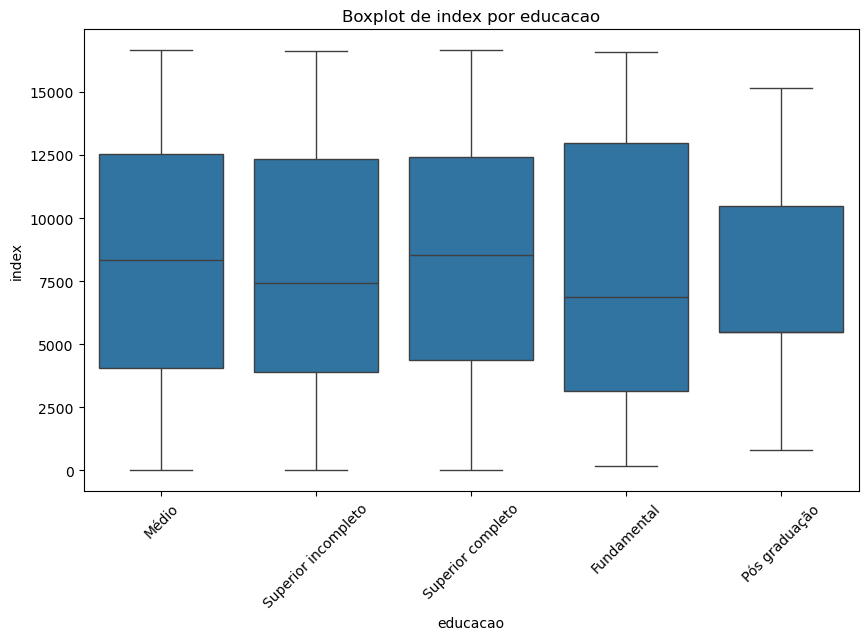

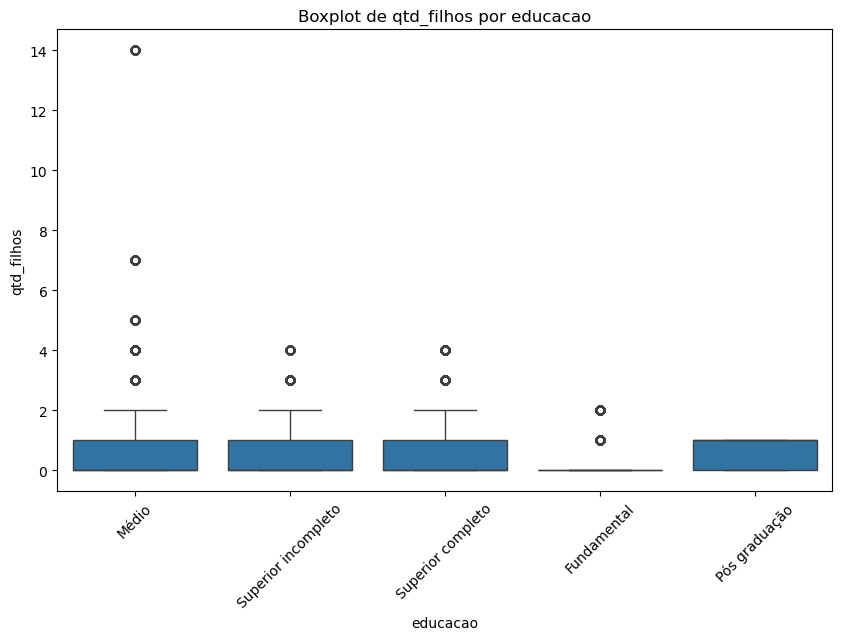

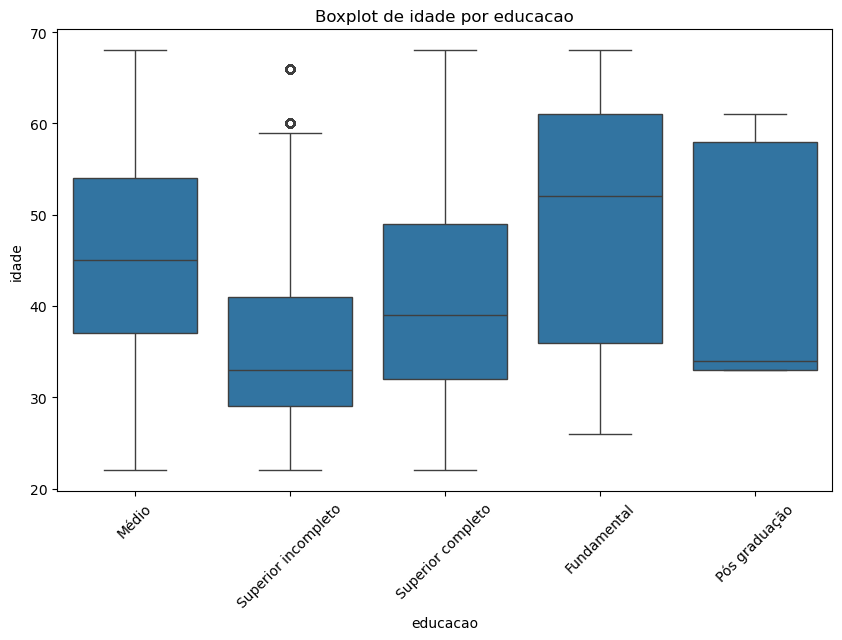

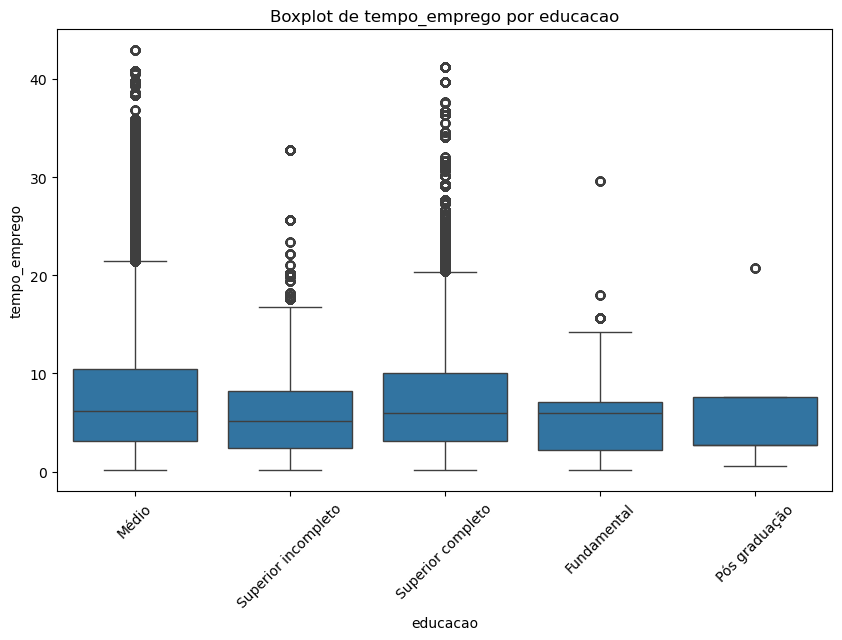

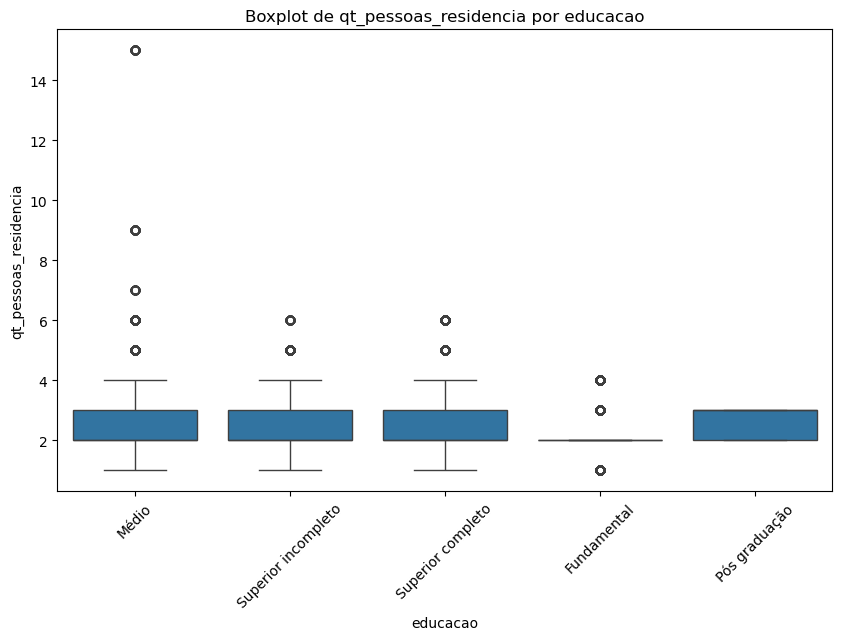

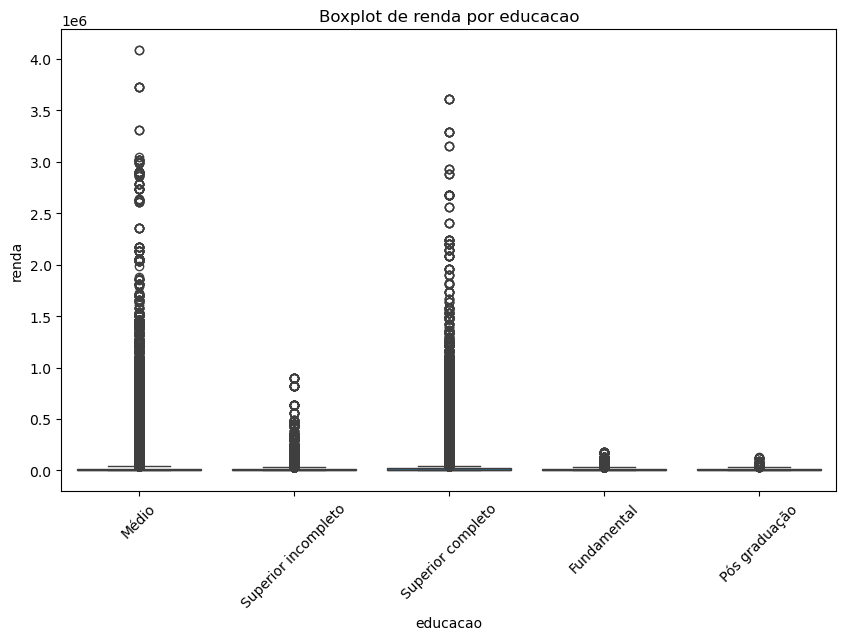

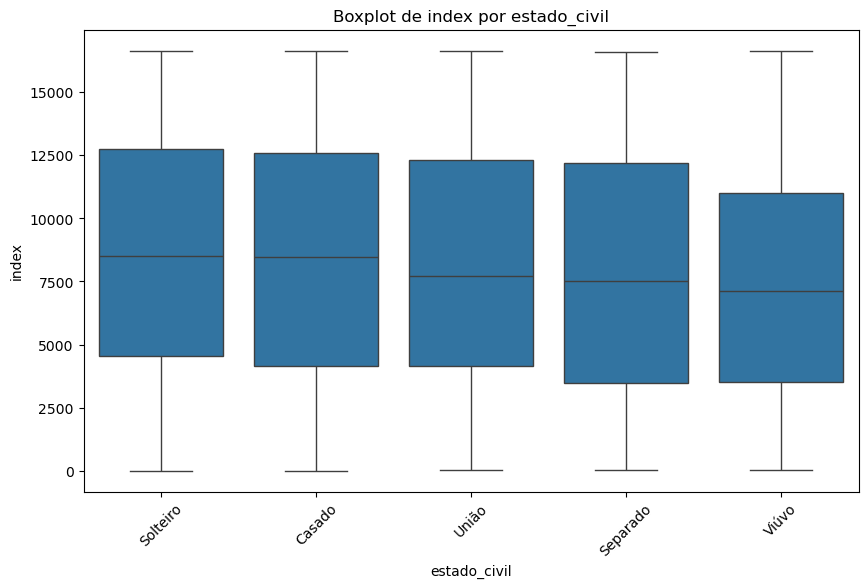

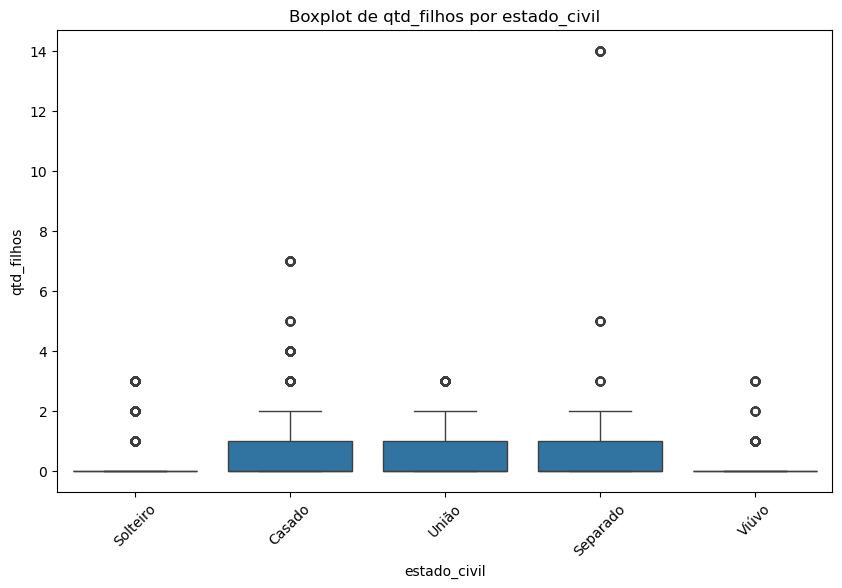

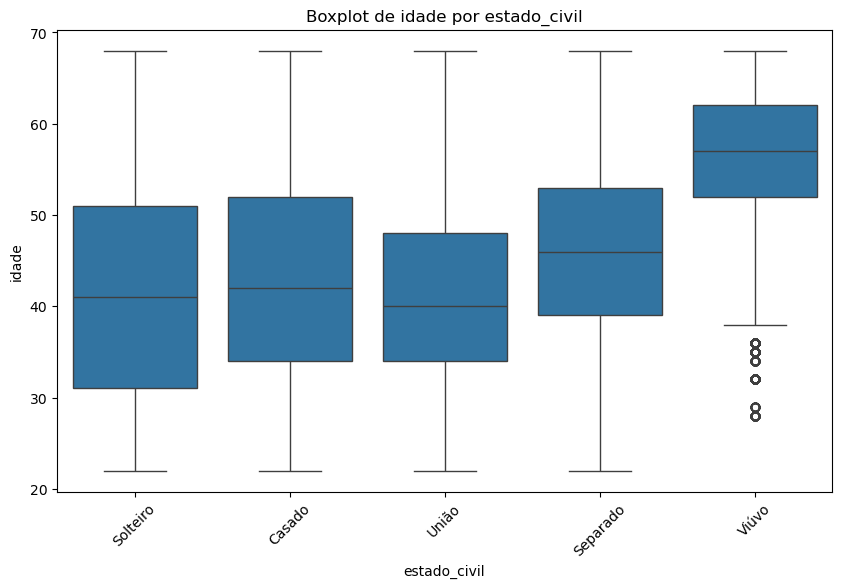

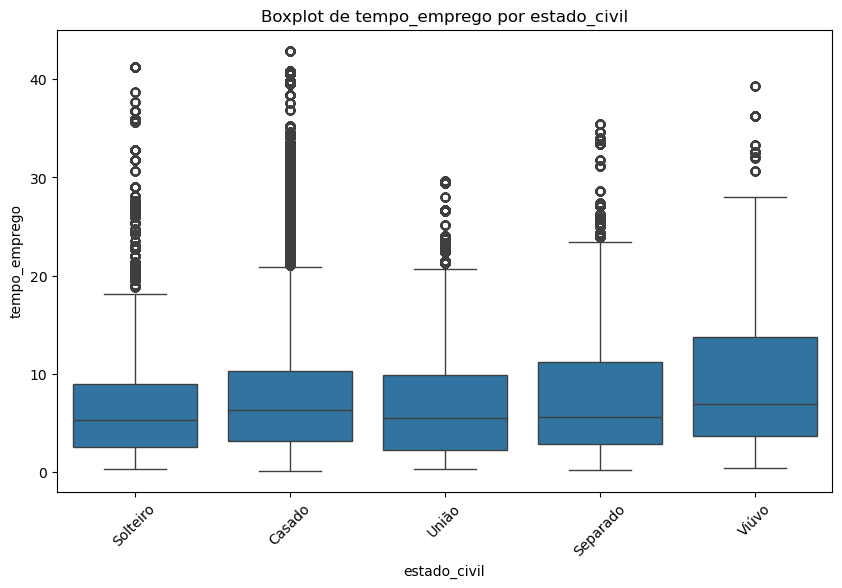

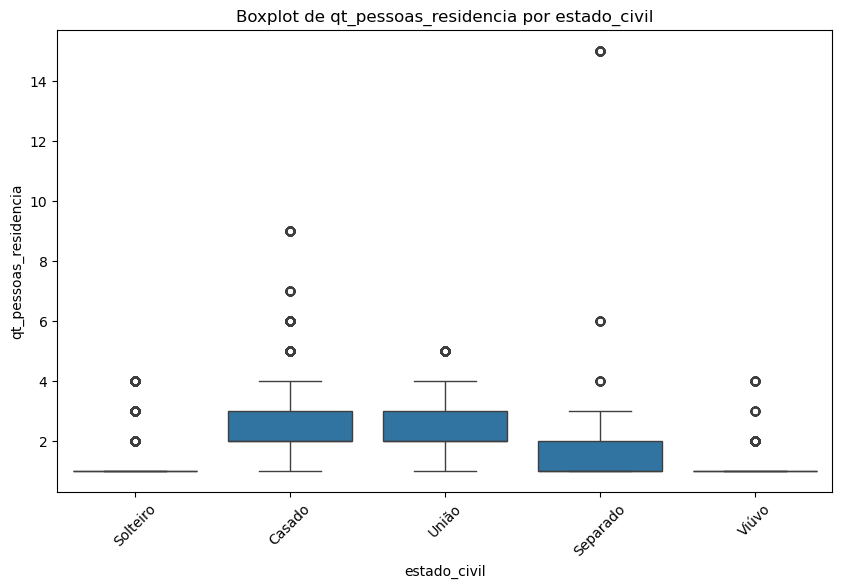

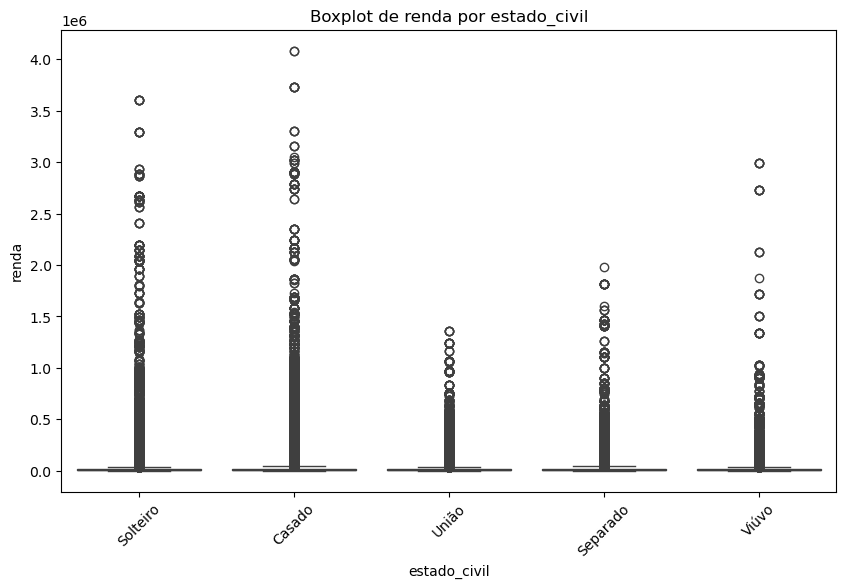

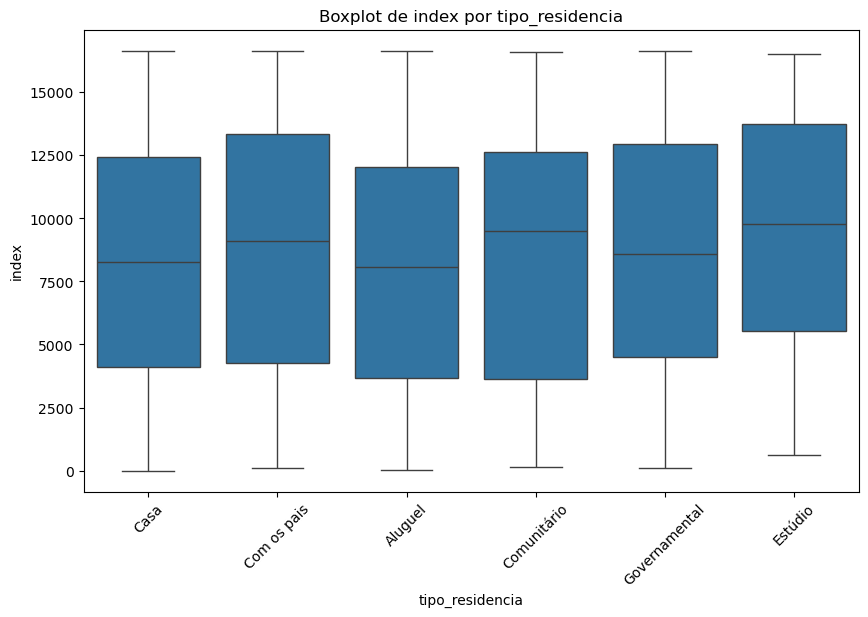

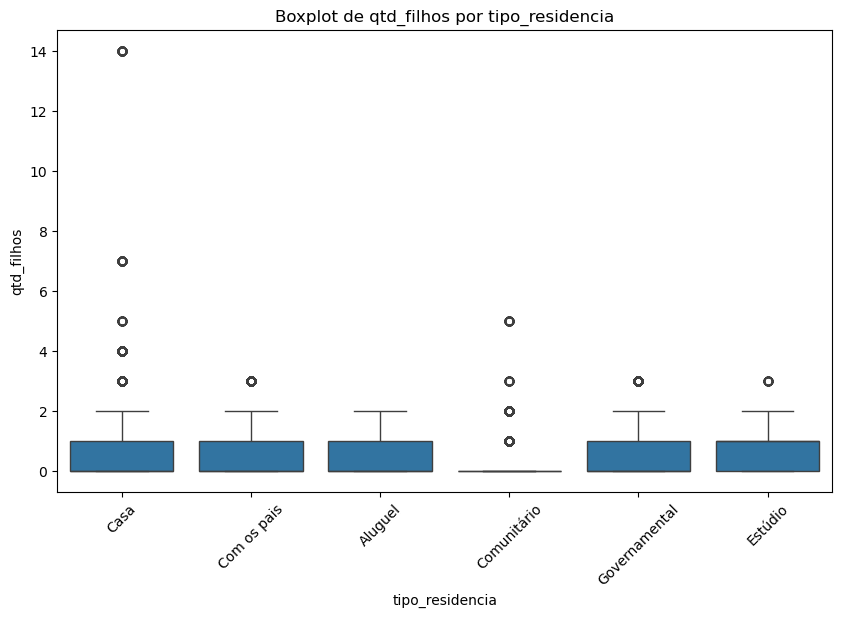

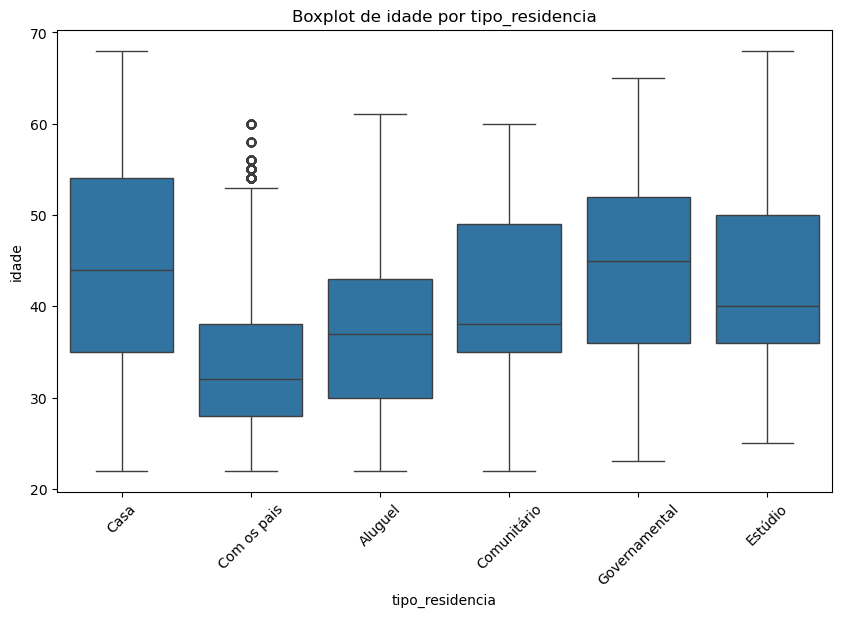

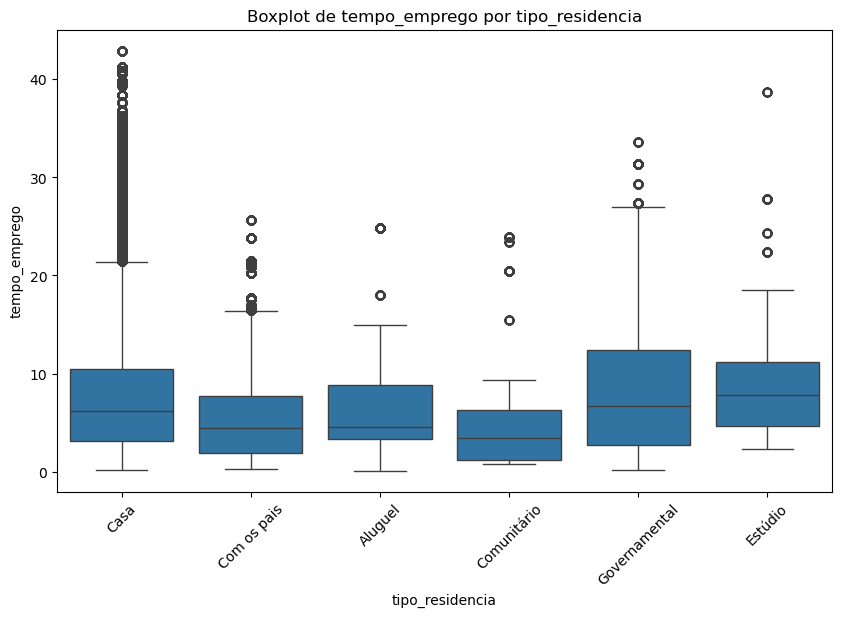

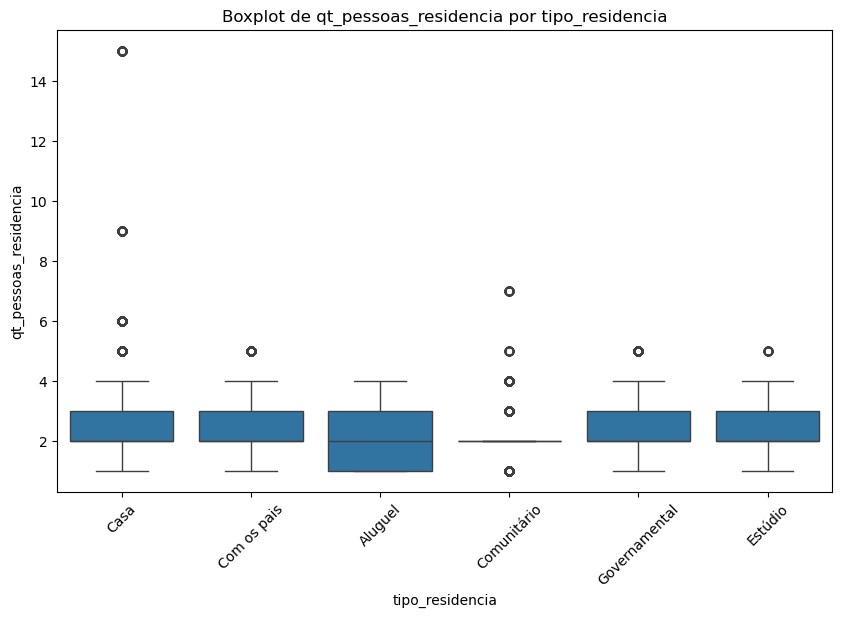

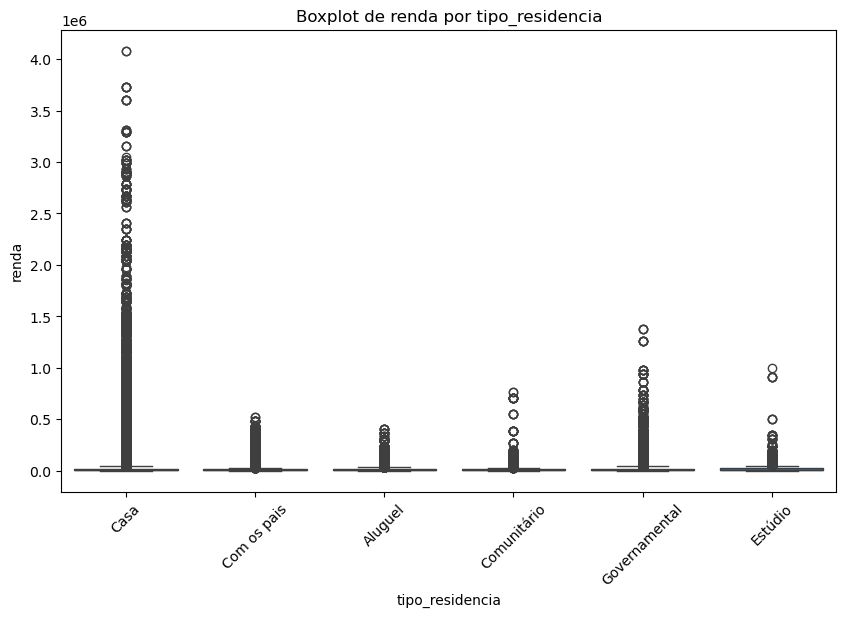

In [30]:
variaveis_quantitativas = df.select_dtypes(include=['float64', 'int64']).columns

correlacao = df[variaveis_quantitativas].corr()
print("Matriz de Correlação:")
print(correlacao)


plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()


variaveis_qualitativas = df.select_dtypes(include=['object']).columns


for i in range(len(variaveis_qualitativas)):
    for j in range(i + 1, len(variaveis_qualitativas)):
        tabela_contingencia = pd.crosstab(df[variaveis_qualitativas[i]], df[variaveis_qualitativas[j]])
        print(f"\nTabela de Contingência entre {variaveis_qualitativas[i]} e {variaveis_qualitativas[j]}:")
        print(tabela_contingencia)


for qual in variaveis_qualitativas:
    for quant in variaveis_quantitativas:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[qual], y=df[quant])
        plt.title(f"Boxplot de {quant} por {qual}")
        plt.xticks(rotation=45)
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [132]:
" + ".join(list(treinamento.columns))

'data_ref + index + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau'

In [178]:
# Tratamento de valores ausentes
treinamento['tempo_emprego'].fillna(treinamento['tempo_emprego'].median(), inplace=True)
validacao_oot['tempo_emprego'].fillna(validacao_oot['tempo_emprego'].median(), inplace=True)  

# Tratamento de zeros estruturais
treinamento['renda'] = treinamento['renda'].replace(0, np.nan)  # Exemplo, substituindo zeros por NaN
treinamento['tem_veiculo'] = np.where(treinamento['posse_de_veiculo'] == 0, 0, 1)  
validacao_oot['tem_veiculo'] = np.where(validacao_oot['posse_de_veiculo'] == 0, 0, 1)  


# Tratamento de outliers
for col in ['renda', 'idade']:  # Exemplo de colunas
    treinamento = treinamento[(treinamento[col] < treinamento[col].quantile(0.95)) & (treinamento[col] > treinamento[col].quantile(0.05))]

In [203]:
formula = '''mau ~  sexo + posse_de_imovel + qtd_filhos + tipo_renda + 
            educacao + estado_civil +  idade + tempo_emprego + renda  + tem_veiculo'''

rl = smf.glm(formula, data=treinamento, family= sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               375722
Model:                                     GLM   Df Residuals:                   375703
Model Family:                         Binomial   Df Model:                           18
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -67756.
Date:                         Wed, 21 Aug 2024   Deviance:                   1.3551e+05
Time:                                 23:10:31   Pearson chi2:                 4.44e+05
No. Iterations:                              8   Pseudo R-squ. (CS):            0.01971
Covariance Type:                     nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.0856      0.051     21.481      0.000       0.987       1.185
sexo[T.M]                           0.0216      0.017      1.271      0.204      -0.012       0.055
posse_de_imovel[T.S]                0.0486      0.017      2.945      0.003       0.016       0.081
tipo_renda[T.Bolsista]             -0.1886      0.300     -0.629      0.529      -0.776       0.399
tipo_renda[T.Empresário]            0.0161      0.019      0.846      0.397      -0.021       0.053
tipo_renda[T.Pensionista]           0.0805      0.029      2.777      0.005       0.024       0.137
tipo_renda[T.Servidor público]      0.0320      0.031      1.036      0.300      -0.029       0.093
educacao[T.Médio]                  -0.0205      0.086     -0.238      0.812      -0.189       0.148
educacao[T.Pós graduação]          -0.2450      0.222     -1.104      0.270      -0.680       0.190
educacao[T.Superior completo]      -0.0137      0.087     -0.157      0.876      -0.185       0.157
educacao[T.Superior incompleto]    -0.0355      0.095     -0.373      0.709      -0.222       0.151
estado_civil[T.Separado]           -0.0052      0.033     -0.159      0.874      -0.069       0.059
estado_civil[T.Solteiro]           -0.0339      0.026     -1.288      0.198      -0.086       0.018
estado_civil[T.União]              -0.0560      0.028     -1.978      0.048      -0.112      -0.001
estado_civil[T.Viúvo]               0.0667      0.046      1.453      0.146      -0.023       0.157
qtd_filhos                         -0.0170      0.011     -1.547      0.122      -0.039       0.005
idade                              -0.0036      0.001     -3.080      0.002      -0.006      -0.001
tempo_emprego                       0.0077      0.002      3.586      0.000       0.003       0.012
renda                             8.64e-05   1.36e-06     63.311      0.000    8.37e-05    8.91e-05
tem_veiculo                         1.0856      0.051     21.481      0.000       0.987       1.185
===================================================================================================
"""

Há  categorias não significantes devido ao p-value acima de 0.5

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [201]:

# Fazer previsões no conjunto de treinamento e validação
y_scores_train = rl.predict(treinamento)
y_scores_oot = rl.predict(validacao_oot)

# Convertendo a variável resposta para numpy array para métricas
y_true_train = treinamento['mau'].values
y_true_oot = validacao_oot['mau'].values

# Acurácia
def accuracy(y_true, y_scores, threshold=0.5):
    y_pred = y_scores > threshold
    return accuracy_score(y_true, y_pred)

accuracy_train = accuracy(y_true_train, y_scores_train)
accuracy_oot = accuracy(y_true_oot, y_scores_oot)

# Teste de Kolmogorov-Smirnov (KS)
def ks_statistic(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return np.max(tpr - fpr)

ks_train = ks_statistic(y_true_train, y_scores_train)
ks_oot = ks_statistic(y_true_oot, y_scores_oot)

# Índice de Gini
def gini_coefficient(y_true, y_scores):
    auc = roc_auc_score(y_true, y_scores)
    return 2 * auc - 1

gini_train = gini_coefficient(y_true_train, y_scores_train)
gini_oot = gini_coefficient(y_true_oot, y_scores_oot)

# Exibindo os resultados
print(f'Acurácia no conjunto de treino: {accuracy_train:.4f}')
print(f'Acurácia no conjunto de validação (out of time): {accuracy_oot:.4f}')
print(f'KS no conjunto de treino: {ks_train:.4f}')
print(f'KS no conjunto de validação (out of time): {ks_oot:.4f}')
print(f'Índice de Gini no conjunto de treino: {gini_train:.4f}')
print(f'Índice de Gini no conjunto de validação (out of time): {gini_oot:.4f}')

Acurácia no conjunto de treino: 0.0472
Acurácia no conjunto de validação (out of time): 0.1452
KS no conjunto de treino: 0.0000
KS no conjunto de validação (out of time): 0.0000
Índice de Gini no conjunto de treino: -0.3983
Índice de Gini no conjunto de validação (out of time): -0.4780
